In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import glob
import os
import json
from PIL import Image
import xml.etree.ElementTree as ET
import pprint
pp = pprint.PrettyPrinter(indent=4)
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
import torchvision.ops as ops
from torch.utils.data import distributed, RandomSampler, SequentialSampler
import random
import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [63]:
TRAIN_PATH = "DUO/splitted/train"
VAL_PATH = "DUO/splitted/val"
TEST_PATH = "DUO/test"

TRAIN_LABELS = TRAIN_PATH + "/labels"
VAL_LABELS = VAL_PATH + "/labels"
TEST_LABELS = TEST_PATH + "/labels"

TRAIN_IMAGES = TRAIN_PATH + "/images"
VAL_IMAGES = VAL_PATH + "/images"
TEST_IMAGES = TEST_PATH + "/images"

# data = "../data/aquarium_pretrain/data.yaml"

In [4]:
import os

def check_labels_images(image_dir, label_dir, image_exts=(".jpg", ".png", ".jpeg"), label_ext=".txt"):
    image_files = set(os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(image_exts))
    label_files = set(os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.endswith(label_ext))

    missing_images = label_files - image_files
    missing_labels = image_files - label_files

    print(f"✅ Total Images: {len(image_files)}")
    print(f"✅ Total Labels: {len(label_files)}")

    if missing_images:
        print(f"❌ Labels without images ({len(missing_images)}):")
        for name in sorted(missing_images):
            print(f" - {name + '.txt'}")

    if missing_labels:
        print(f"❌ Images without labels ({len(missing_labels)}):")
        for name in sorted(missing_labels):
            print(f" - {name + '.jpg'}")

    if not missing_images and not missing_labels:
        print("🎉 All labels and images match!")

# Example usage:
check_labels_images(
    image_dir=TRAIN_IMAGES,
    label_dir=TRAIN_LABELS
)


✅ Total Images: 3488
✅ Total Labels: 3488
🎉 All labels and images match!


In [5]:
DESTINATION_PATH = "DUO"

TRAIN_DESTINATION = DESTINATION_PATH + "/train2"
VAL_DESTINATION = DESTINATION_PATH + "/val2"
TEST_DESTINATION = DESTINATION_PATH + "/test2"

Processing image 1/4...
Processing image 2/4...
Processing image 3/4...
Processing image 4/4...
Saved mosaic image and labels to DUO/train2\2370_2371_2372_2373.jpg and DUO/train2/labels\2370_2371_2372_2373.txt


In [ ]:
# # Notebook cell: Verify YOLO label normalization

# import os
# import glob
# import pandas as pd
# from IPython.display import display, Markdown

# # === USER EDITABLE: point this to your labels folder ===
# label_dir = TRAIN_LABELS

# # collect all .txt files
# label_files = glob.glob(os.path.join(label_dir, "*.txt"))

# out_of_range = []
# for lf in label_files:
#     with open(lf, 'r') as f:
#         for line_no, line in enumerate(f, start=1):
#             parts = line.strip().split()
#             if len(parts) != 5:
#                 continue
#             cls, xc, yc, w, h = parts
#             coords = {
#                 "x_center": float(xc),
#                 "y_center": float(yc),
#                 "width":     float(w),
#                 "height":    float(h)
#             }
#             for name, val in coords.items():
#                 if not (0.0 <= val <= 1.0):
#                     out_of_range.append({
#                         "file": os.path.basename(lf),
#                         "line": line_no,
#                         "coord": name,
#                         "value": val
#                     })

# df = pd.DataFrame(out_of_range)

# if df.empty:
#     display(Markdown("✅ **All YOLO label coordinates are normalized in [0.0, 1.0].**"))
# else:
#     display(Markdown(f"⚠️ **Found {len(df)} out‑of‑range coordinate(s):**"))
#     display(df)


✅ **All YOLO label coordinates are normalized in [0.0, 1.0].**

In [8]:
# #!/usr/bin/env python3
# import os
# import json
# import argparse
# from collections import defaultdict

# def coco_to_yolo(coco_json_path, output_dir):
#     # Load COCO JSON
#     with open(coco_json_path, 'r') as f:
#         coco = json.load(f)

#     # Build image metadata lookup: image_id -> (file_name, width, height)
#     images = {img['id']: (img['file_name'], img['width'], img['height'])
#               for img in coco.get('images', [])}

#     # Build annotations grouped by image_id
#     annos_per_image = defaultdict(list)
#     for ann in coco.get('annotations', []):
#         image_id = ann['image_id']
#         annos_per_image[image_id].append(ann)

#     # Build category_id → new sequential class_id mapping (0…N-1)
#     all_cat_ids = sorted({cat['id'] for cat in coco.get('categories', [])})
#     catid2class = {cat_id: idx for idx, cat_id in enumerate(all_cat_ids)}
#     print("Category ID to class index mapping:")
#     for cat_id, cls in catid2class.items():
#         print(f"  COCO cat {cat_id} → YOLO cls {cls}")

#     # Make sure output directory exists
#     os.makedirs(output_dir, exist_ok=True)

#     # Process each image
#     for image_id, (file_name, width, height) in images.items():
#         yolo_lines = []
#         for ann in annos_per_image.get(image_id, []):
#             bbox = ann['bbox']  # [x_min, y_min, box_w, box_h]
#             x, y, w, h = bbox
#             # Compute centers
#             x_c = x + w / 2
#             y_c = y + h / 2

#             # Normalize
#             x_c_norm = x_c / width
#             y_c_norm = y_c / height
#             w_norm   = w   / width
#             h_norm   = h   / height

#             # Check & warn if any not in [0,1]
#             for name, val in [('x_center', x_c_norm), ('y_center', y_c_norm),
#                               ('w', w_norm), ('h', h_norm)]:
#                 if not (0.0 <= val <= 1.0):
#                     print(f"WARNING: {name}={val:.4f} out of [0,1] for image '{file_name}'. "
#                           "Normalizing anyway.")
#                     # Clip to [0,1]
#                     val_clipped = max(0.0, min(1.0, val))
#                     if name == 'x_center':
#                         x_c_norm = val_clipped
#                     elif name == 'y_center':
#                         y_c_norm = val_clipped
#                     elif name == 'w':
#                         w_norm = val_clipped
#                     elif name == 'h':
#                         h_norm = val_clipped

#             cls_id = catid2class.get(ann['category_id'], None)
#             if cls_id is None:
#                 print(f"WARNING: annotation with unknown category_id {ann['category_id']} skipped.")
#                 continue

#             yolo_lines.append(f"{cls_id} "
#                               f"{x_c_norm:.6f} {y_c_norm:.6f} "
#                               f"{w_norm:.6f} {h_norm:.6f}")

#         # Write .txt file (same base name as image)
#         base, _ = os.path.splitext(file_name)
#         out_path = os.path.join(output_dir, base + '.txt')
#         with open(out_path, 'w') as f:
#             f.write("\n".join(yolo_lines))

#     print(f"Done! YOLO annotations saved to '{output_dir}'.")



In [9]:
# coco_to_yolo(
#     coco_json_path='D:/underwater_OD/DUO/test/instances_test.json',
#     output_dir='D:/underwater_OD/DUO/test/labels'  # or './DUO/train'
# )

In [10]:
# import os
# import random
# import shutil

# def split_dataset(images_dir, labels_dir, output_dir,
#                   train_ratio=0.8, seed=None, move_val=False):
#     """
#     Split a YOLO-formatted dataset into train and validation sets.

#     Args:
#         images_dir (str): Directory containing image files.
#         labels_dir (str): Directory containing YOLO .txt label files.
#         output_dir (str): Root directory where 'train' and 'val' folders will be created.
#         train_ratio (float): Fraction of data to use for training (default: 0.8).
#         seed (int, optional): Random seed for reproducibility.
#         move_val (bool): If True, move val files out of source dirs (removing them).
#     """
#     # Make output subdirectories
#     for split in ('train', 'val'):
#         for sub in ('images', 'labels'):
#             os.makedirs(os.path.join(output_dir, split, sub), exist_ok=True)

#     # Gather image files
#     exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
#     image_files = [f for f in os.listdir(images_dir)
#                    if os.path.splitext(f)[1].lower() in exts]

#     # Pair images with labels
#     pairs = []
#     for img in image_files:
#         base = os.path.splitext(img)[0]
#         label_path = os.path.join(labels_dir, base + '.txt')
#         if os.path.exists(label_path):
#             pairs.append((img, label_path))
#         else:
#             print(f"WARNING: Missing label for {img}, skipping.")

#     # Shuffle and split
#     if seed is not None:
#         random.seed(seed)
#     random.shuffle(pairs)
#     n_train = int(len(pairs) * train_ratio)
#     train_pairs = pairs[:n_train]
#     val_pairs = pairs[n_train:]

#     # Copy train pairs
#     for img_file, lbl_path in train_pairs:
#         src_img = os.path.join(images_dir, img_file)
#         dst_img = os.path.join(output_dir, 'train', 'images', img_file)
#         shutil.copy2(src_img, dst_img)
#         dst_lbl = os.path.join(output_dir, 'train', 'labels', os.path.basename(lbl_path))
#         shutil.copy2(lbl_path, dst_lbl)

#     # Handle val pairs: copy or move
#     for img_file, lbl_path in val_pairs:
#         src_img = os.path.join(images_dir, img_file)
#         dst_img = os.path.join(output_dir, 'val', 'images', img_file)
#         src_lbl = lbl_path
#         dst_lbl = os.path.join(output_dir, 'val', 'labels', os.path.basename(lbl_path))

#         if move_val:
#             shutil.move(src_img, dst_img)
#             shutil.move(src_lbl, dst_lbl)
#         else:
#             shutil.copy2(src_img, dst_img)
#             shutil.copy2(src_lbl, dst_lbl)

#     action = 'moved' if move_val else 'copied'
#     print(f"Split complete: {len(train_pairs)} train (copied), {len(val_pairs)} val ({action}).")

# # Example usage in a notebook cell:
# # split_dataset(
# #     images_dir='D:/underwater_OD/DUO/train/images',
# #     labels_dir='D:/underwater_OD/DUO/train/labels',
# #     output_dir='D:/underwater_OD/DUO',
# #     train_ratio=0.8,
# #     seed=42,
# #     move_val=True  # remove val images from train dir
# # )


In [11]:
# split_dataset(
#     images_dir='D:/underwater_OD/DUO/train_original/images',
#     labels_dir='D:/underwater_OD/DUO/train_original/labels',
#     output_dir='D:/underwater_OD/DUO/splitted',
#     train_ratio=0.8,
#     seed=42
# )


In [12]:
classes = ["holothurian", "echinus", "scallop","starfish"]
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print("Index to Label Mapping:", Idx2Label)
print("Label to Index Mapping:", Label2Index)

Index to Label Mapping: {0: 'holothurian', 1: 'echinus', 2: 'scallop', 3: 'starfish'}
Label to Index Mapping: {'holothurian': 0, 'echinus': 1, 'scallop': 2, 'starfish': 3}


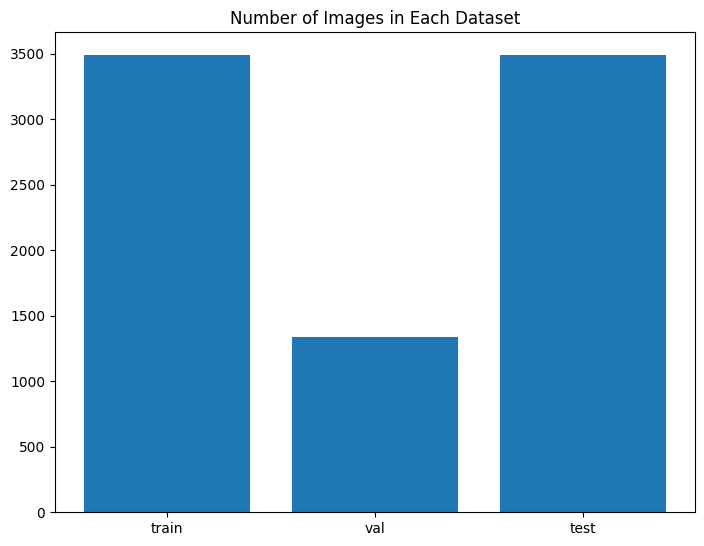

In [13]:
def plot_num_images(data, title):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(data.keys(), data.values())
    plt.title(title)
    plt.show()
    
def get_num_images(path):
    return len(os.listdir(path))

plot_num_images({ "train": get_num_images(TRAIN_IMAGES), "val": get_num_images(VAL_IMAGES), "test": get_num_images(TEST_IMAGES) }, "Number of Images in Each Dataset")

In [14]:
def count_objects_per_images(image_dir, label_dir, object_count, total_object_count):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm(image_files):
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        total_object_count.append(len(lines))
        for line in lines:
            object_count[Idx2Label[int(line.split()[0])]] = object_count.get(Idx2Label[int(line.split()[0])], 0) + 1
        f.close()
        
train_object_count = {}
val_object_count = {}
test_object_count = {}

total_object_per_train_count = []
total_object_per_val_count = []
total_object_per_test_count = []

count_objects_per_images(TRAIN_IMAGES, TRAIN_LABELS, train_object_count, total_object_per_train_count)
count_objects_per_images(VAL_IMAGES, VAL_LABELS, val_object_count, total_object_per_val_count)
count_objects_per_images(TEST_IMAGES, TEST_LABELS, test_object_count, total_object_per_test_count)

100%|██████████| 3488/3488 [00:00<00:00, 21136.38it/s]


In [15]:
pp.pprint(train_object_count)
print()
pp.pprint(val_object_count)
print()
pp.pprint(test_object_count)

{'echinus': 22423, 'holothurian': 3614, 'scallop': 901, 'starfish': 6388}

{'echinus': 8870, 'holothurian': 1324, 'scallop': 375, 'starfish': 2547}

{'echinus': 22423, 'holothurian': 3614, 'scallop': 901, 'starfish': 6388}


In [ ]:
def plot_object_count(object_count, title):
    plt.figure(figsize=(12, 6))
    plt.bar(object_count.keys(), object_count.values())
    plt.title(title)
    plt.show()
    
plot_object_count(train_object_count, "Train Object Count")
plot_object_count(val_object_count, "Validation Object Count")
plot_object_count(test_object_count, "Test Object Count")

In [ ]:
total_object_count = {label: train_object_count.get(label, 0) + val_object_count.get(label, 0) + test_object_count.get(label, 0) for label in classes}
plot_object_count(total_object_count, "Total Object Count")

In [ ]:
def plot_total_object_per_image(total_object_per_image, title):
    plt.figure(figsize=(12, 6))
    plt.hist(total_object_per_image, bins=20)
    plt.title(title)
    plt.show()
    
plot_total_object_per_image(total_object_per_train_count, "Total Object Per Train Image")
plot_total_object_per_image(total_object_per_val_count, "Total Object Per Validation Image")
plot_total_object_per_image(total_object_per_test_count, "Total Object Per Test Image")

In [19]:
def get_bbox_sizes(image_dir, label_dir, sizes):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm(image_files):
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        for line in lines:
            sizes.append(float(line.split()[3]) * float(line.split()[4]))
        f.close()
        
train_sizes = []
val_sizes = []
test_sizes = []

get_bbox_sizes(TRAIN_IMAGES, TRAIN_LABELS, train_sizes)
get_bbox_sizes(VAL_IMAGES, VAL_LABELS, val_sizes)
get_bbox_sizes(TEST_IMAGES, TEST_LABELS, test_sizes)

100%|██████████| 3488/3488 [00:00<00:00, 21227.37it/s]


In [ ]:
def plot_bbox_sizes(sizes, title):
    plt.figure(figsize=(12, 6))
    plt.hist(sizes, bins=20)
    plt.title(title)
    plt.xlim(0, .2)
    plt.show()
    
plot_bbox_sizes(train_sizes, "Train Bounding Box Sizes")
plot_bbox_sizes(val_sizes, "Validation Bounding Box Sizes")
plot_bbox_sizes(test_sizes, "Test Bounding Box Sizes")

In [ ]:
def plot_all_bbox_sizes(train_sizes, val_sizes, test_sizes, title):
    plt.figure(figsize=(12, 6))
    plt.hist(train_sizes, bins=20, alpha=0.5, label="Train")
    plt.hist(val_sizes, bins=20, alpha=0.5, label="Validation")
    plt.hist(test_sizes, bins=20, alpha=0.5, label="Test")
    plt.title(title)
    plt.xlim(0, .2)
    plt.legend()
    plt.show()
    
plot_all_bbox_sizes(train_sizes, val_sizes, test_sizes, "All Bounding Box Sizes")

In [ ]:
def count_width_height(image_dir, label_dir, width_height):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm(image_files):
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        for line in lines:
            width_height.append((float(line.split()[3]), float(line.split()[4])))
        f.close()
        
train_width_height = []
val_width_height = []
test_width_height = []

count_width_height(TRAIN_IMAGES, TRAIN_LABELS, train_width_height)
count_width_height(VAL_IMAGES, VAL_LABELS, val_width_height)
count_width_height(TEST_IMAGES, TEST_LABELS, test_width_height)

In [ ]:
def plot_width_height(width_height, title):
    width, height = zip(*width_height)
    plt.figure(figsize=(12, 6))
    plt.hist(width, bins=20, alpha=0.5, label="Width")
    plt.hist(height, bins=20, alpha=0.5, label="Height")
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_width_height(train_width_height, "Train Width and Height")
plot_width_height(val_width_height, "Validation Width and Height")
plot_width_height(test_width_height, "Test Width and Height")

In [ ]:
def plot_width_height_scatter(width_height, title):
    width, height = zip(*width_height)
    plt.figure(figsize=(12, 6))
    plt.scatter(width, height)
    plt.title(title)
    plt.show()
    
plot_width_height_scatter(train_width_height, "Train Width vs Height")
plot_width_height_scatter(val_width_height, "Validation Width vs Height")
plot_width_height_scatter(test_width_height, "Test Width vs Height")

In [ ]:
def plot_all_width_height_scatter(train_width_height, val_width_height, test_width_height, title):
    train_width, train_height = zip(*train_width_height)
    val_width, val_height = zip(*val_width_height)
    test_width, test_height = zip(*test_width_height)
    plt.figure(figsize=(12, 6))
    plt.scatter(train_width, train_height, alpha=0.5, label="Train")
    plt.scatter(val_width, val_height, alpha=0.5, label="Validation")
    plt.scatter(test_width, test_height, alpha=0.5, label="Test")
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_all_width_height_scatter(train_width_height, val_width_height, test_width_height, "All Width vs Height")

In [ ]:
def plot_all_aspect_ratios(train_width_height, val_width_height, test_width_height, title):
    EPSILON = 1e-6
            
    train_aspect_ratio = [w / h if h != 0 else w / (h + EPSILON) for w, h in train_width_height] 
    val_aspect_ratio = [w / h if h != 0 else w / (h + EPSILON) for w, h in val_width_height]
    test_aspect_ratio = [w / h if h != 0 else w / (h + EPSILON) for w, h in test_width_height]
    
    plt.figure(figsize=(12, 6))
    plt.hist(train_aspect_ratio, alpha=0.5, label="Train", bins=50)
    plt.hist(val_aspect_ratio, alpha=0.5, label="Validation", bins=50)
    plt.hist(test_aspect_ratio, alpha=0.5, label="Test", bins=50)
    plt.title(title)
    plt.legend()
    plt.show()

plot_all_aspect_ratios(train_width_height, val_width_height, test_width_height, "All Aspect Ratios")

In [ ]:
def visualize_image_with_annotation_bounding_boxes(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))

    sample_image_files = random.sample(image_files, 12)

    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")

        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width / 2) * w)
            y_min = int((y_center - height / 2) * h)
            x_max = int((x_center + width / 2) * w)
            y_max = int((y_center + height / 2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(
                image,
                Idx2Label[int(class_id)],
                (x_min, y_min),
                cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(255, 255, 255),
                thickness=2,
            )

        axs[row, col].imshow(image)
        axs[row, col].axis("off")

    plt.show()


visualize_image_with_annotation_bounding_boxes(TRAIN_IMAGES, TRAIN_LABELS)

In [31]:
# normalize_labels(
#     image_dir='DUO/val/images',
#     label_dir='DUO/val/labels',
#     image_dest='DUO/val_norm/images',
#     label_dest='DUO/val_norm/labels',
#     img_size=640,
#     square=False
# )

In [1]:
def get_train_aug():
    return A.Compose(
        [
            A.OneOf(
                [
                    A.Blur(blur_limit=3, p=0.5),
                    A.MotionBlur(blur_limit=3, p=0.5),
                    A.MedianBlur(blur_limit=3, p=0.5),
                ],
                p=0.5,
            ),
            A.ToGray(p=0.1),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            A.RandomGamma(p=0.1),
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["labels"],
        ),
    )


def get_train_transform():
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["labels"],
        ),
    )


def get_valid_transform():
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["labels"],
        ),
    )


def infer_transforms(image):
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ]
    )
    return transform(image)


def preprocess(image_name, image_dir, label_dir):
    image_path = os.path.sep.join([image_dir, image_name])
    name = image_name.split(".")[0]
    label_name = name + ".txt"
    label_path = os.path.sep.join([label_dir, label_name])

    return image_path, label_path, label_name


def draw_rect(img, bboxes, color=(255, 0, 0)):
    img = img.copy()
    height, width = img.shape[:2]
    for bbox in bboxes:
        center_x, center_y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        x = int((center_x - w / 2) * width)
        w = int(w * width)
        y = int((center_y - h / 2) * height)
        h = int(h * height)
        img = cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
    return img


def read_img(image_path, cvt_color=True):
    img = cv2.imread(image_path)
    if cvt_color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def save_img(image, save_path, jpg_quality=None):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if jpg_quality:
        cv2.imwrite(save_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality])
    else:
        cv2.imwrite(save_path, image)


def read_label(label_path):
    with open(label_path) as f:
        conts = f.readlines()

    bboxes = []
    class_labels = []
    for cont in conts:
        cont = cont.strip().split()
        center_x, center_y, w, h = (
            float(cont[1]),
            float(cont[2]),
            float(cont[3]),
            float(cont[4]),
        )
        bboxes.append([center_x, center_y, w, h])
        class_labels.append(cont[0])
    return (bboxes, class_labels)


def display_img(image_path, label_path):
    img = read_img(image_path, cvt_color=False)
    bboxes = read_label(label_path)[0]
    img = draw_rect(img, bboxes)
    cv2.imshow("Image", img)
    cv2.waitKey(0)


def save_label(bboxes, class_labels, label_path):
    tem_lst = []
    for i, bbox in enumerate(bboxes):
        tem_lst.append(
            class_labels[i]
            + " "
            + str(bbox[0])
            + " "
            + str(bbox[1])
            + " "
            + str(bbox[2])
            + " "
            + str(bbox[3])
            + "\n"
        )

    with open(label_path, "w") as f:
        f.writelines(tem_lst)



import cv2
import os
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2


def random_crop_savebboxes(
    image_name, image_dir, label_dir, expected_h, expected_w, min_area, min_visibility
):
    image_path, label_path, _ = preprocess(image_name, image_dir, label_dir)

    (bboxes, class_labels) = read_label(label_path)

    transform = A.Compose(
        [A.RandomResizedCrop(size=(expected_h, expected_w))],
        bbox_params=A.BboxParams(
            format="yolo",
            label_fields=["class_labels"],
            min_area=min_area,
            min_visibility=min_visibility,
        ),
    )
    bboxes = np.clip(bboxes, 0.0, 1.0)  # <-- clamp values
# transformed = transform(image=read_img(image_path), bboxes=bboxes, class_labels=class_labels)

    transformed = transform(image=read_img(image_path), bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed["image"]
    transformed_bboxes = transformed["bboxes"]
    transformed_class_labels = transformed["class_labels"]

    return transformed_image, transformed_bboxes, transformed_class_labels


def mosaic(
    image_file_list,
    image_dir,
    label_dir,
    output_image_dir,
    output_label_dir,
    mo_w,
    mo_h,
    scale_x,
    scale_y,
    min_area,
    min_visibility,
    show_image=False,
):
    # Ensure output directories exist
    if not os.path.exists(output_image_dir):
        os.makedirs(output_image_dir)

    if not os.path.exists(output_label_dir):
        os.makedirs(output_label_dir)

    new_img = np.zeros((mo_h, mo_w, 3), dtype="uint8")

    div_point_x = int(mo_w * scale_x)
    div_point_y = int(mo_h * scale_y)

    # Initialize variables to store all bounding boxes and labels
    new_bboxes = []
    new_class_labels = []

    for i in range(len(image_file_list)):
        print(f"Processing image {i + 1}/{len(image_file_list)}...")

        if i == 0:
            w0 = div_point_x
            h0 = div_point_y
            img_0, bboxes_0, class_labels_0 = random_crop_savebboxes(
                image_file_list[0],
                image_dir,
                label_dir,
                h0,
                w0,
                min_area,
                min_visibility,
            )
            new_img[:div_point_y, :div_point_x, :] = img_0

            if len(bboxes_0) == 0:
                bboxes_0_new = []
            else:
                bboxes_0_new = np.zeros((len(bboxes_0), 4))
                bboxes_0_new = bboxes_0_new.tolist()

            for i, box in enumerate(bboxes_0):
                bboxes_0_new[i][0] = box[0] * scale_x
                bboxes_0_new[i][2] = box[2] * scale_x

                bboxes_0_new[i][1] = box[1] * scale_y
                bboxes_0_new[i][3] = box[3] * scale_y

            new_bboxes.extend(bboxes_0_new)
            new_class_labels.extend(class_labels_0)

        elif i == 1:
            w1 = mo_w - div_point_x
            h1 = div_point_y
            img_1, bboxes_1, class_labels_1 = random_crop_savebboxes(
                image_file_list[1],
                image_dir,
                label_dir,
                h1,
                w1,
                min_area,
                min_visibility,
            )
            new_img[:div_point_y, div_point_x:, :] = img_1

            if len(bboxes_1) == 0:
                bboxes_1_new = []
            else:
                bboxes_1_new = np.zeros((len(bboxes_1), 4))
                bboxes_1_new = bboxes_1_new.tolist()

            for i, box in enumerate(bboxes_1):
                bboxes_1_new[i][0] = box[0] * (1 - scale_x) + scale_x
                bboxes_1_new[i][2] = box[2] * (1 - scale_x)

                bboxes_1_new[i][1] = box[1] * scale_y
                bboxes_1_new[i][3] = box[3] * scale_y

            new_bboxes.extend(bboxes_1_new)
            new_class_labels.extend(class_labels_1)

        elif i == 2:
            w2 = div_point_x
            h2 = mo_h - div_point_y
            img_2, bboxes_2, class_labels_2 = random_crop_savebboxes(
                image_file_list[2],
                image_dir,
                label_dir,
                h2,
                w2,
                min_area,
                min_visibility,
            )
            new_img[div_point_y:, :div_point_x, :] = img_2

            if len(bboxes_2) == 0:
                bboxes_2_new = []
            else:
                bboxes_2_new = np.zeros((len(bboxes_2), 4))
                bboxes_2_new = bboxes_2_new.tolist()

            for i, box in enumerate(bboxes_2):
                bboxes_2_new[i][0] = box[0] * scale_x
                bboxes_2_new[i][2] = box[2] * scale_x

                bboxes_2_new[i][1] = box[1] * (1 - scale_y) + scale_y
                bboxes_2_new[i][3] = box[3] * (1 - scale_y)

            new_bboxes.extend(bboxes_2_new)
            new_class_labels.extend(class_labels_2)

        else:
            w3 = mo_w - div_point_x
            h3 = mo_h - div_point_y
            img_3, bboxes_3, class_labels_3 = random_crop_savebboxes(
                image_file_list[3],
                image_dir,
                label_dir,
                h3,
                w3,
                min_area,
                min_visibility,
            )
            new_img[div_point_y:, div_point_x:, :] = img_3

            if len(bboxes_3) == 0:
                bboxes_3_new = []
            else:
                bboxes_3_new = np.zeros((len(bboxes_3), 4))
                bboxes_3_new = bboxes_3_new.tolist()

            for i, box in enumerate(bboxes_3):
                bboxes_3_new[i][0] = box[0] * (1 - scale_x) + scale_x
                bboxes_3_new[i][2] = box[2] * (1 - scale_x)

                bboxes_3_new[i][1] = box[1] * (1 - scale_y) + scale_y
                bboxes_3_new[i][3] = box[3] * (1 - scale_y)

            new_bboxes.extend(bboxes_3_new)
            new_class_labels.extend(class_labels_3)

    # Generate unique output file names
    mosaic_image_name = "_".join([img.split(".")[0] for img in image_file_list]) + ".jpg"
    mosaic_label_name = "_".join([img.split(".")[0] for img in image_file_list]) + ".txt"

    # Paths for saving the mosaic image and label
    image_store_path = os.path.join(output_image_dir, mosaic_image_name)
    label_store_path = os.path.join(output_label_dir, mosaic_label_name)

    # Save the mosaic image and bounding box labels
    save_img(new_img, image_store_path)
    save_label(new_bboxes, new_class_labels, label_store_path)
    l,.2.imshow("Mosaic Image", new_img)
    cv2.waitKey(1)  # Non-blocking

    print(f"Saved mosaic image and labels to {image_store_path} and {label_store_path}")



def draw_text(
    img,
    text,
    font=cv2.FONT_HERSHEY_SIMPLEX,
    pos=(0, 0),
    font_scale=1,
    font_thickness=2,
    text_color=(0, 255, 0),
    text_color_bg=(0, 0, 0),
):
    offset = (5, 5)
    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    rec_start = tuple(x - y for x, y in zip(pos, offset))
    rec_end = tuple(x + y for x, y in zip((x + text_w, y + text_h), offset))
    cv2.rectangle(img, rec_start, rec_end, text_color_bg, -1)
    cv2.putText(
        img,
        text,
        (x, int(y + text_h + font_scale - 1)),
        font,
        font_scale,
        text_color,
        font_thickness,
        cv2.LINE_AA,
    )
    return img


mosaic(
    ["2370.jpg", "2371.jpg", "2372.jpg", "2373.jpg"],
    TRAIN_IMAGES,
    TRAIN_LABELS,
    TRAIN_DESTINATION,
    TRAIN_DESTINATION+'/labels',
    640,
    640,
    0.5,
    0.5,
    0.1,
    0.3,
    show_image=True,
)


NameError: name 'TRAIN_IMAGES' is not defined

### DataLoader

We will create a custom dataset class to load the images and annotations from the dataset and apply the data augmentation techniques. We will also create a data loader to load the data in batches and shuffle it during training.

In [ ]:



import os
import glob
import cv2
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(
        self,
        images_path,
        labels_path,
        img_size=(640, 640),
        classes=None,
        transforms=None,
        use_train_aug=False,
        train=False,
        mosaic=1.0,
        square_training=False,
    ):
        """
        Args:
            images_path (str): Path to the images directory.
            labels_path (str): Path to the labels directory.
            img_size (tuple): Desired image size (width, height).
            classes (list, optional): List of class labels (unused but kept for interface).
            transforms (callable, optional): Transformations to be applied to the images.
            use_train_aug (bool, optional): Unused augmentation flag (kept for compatibility).
            train (bool, optional): Unused training flag (kept for compatibility).
            mosaic (float, optional): Unused mosaic factor (kept for compatibility).
            square_training (bool, optional): Unused square training flag.
        """
        self.transforms = transforms
        # Store additional flags for compatibility
        self.use_train_aug = use_train_aug
        self.train = train
        self.mosaic = mosaic
        self.square_training = square_training

        self.images_path = images_path
        self.labels_path = labels_path
        self.img_size = img_size

        # collect image paths
        exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.JPG", "*.JPEG", "*.PNG", "*.BMP"]
        self.all_image_paths = []
        for e in exts:
            self.all_image_paths.extend(glob.glob(os.path.join(images_path, e)))
        self.all_image_paths = sorted(set(self.all_image_paths))

        # label paths (not directly used, but count for info)
        self.all_label_paths = sorted(glob.glob(os.path.join(labels_path, "*.txt")))

        print(f"Image count: {len(self.all_image_paths)}")
        print(f"Label count: {len(self.all_label_paths)}")

    def __len__(self):
        return len(self.all_image_paths)

    def __getitem__(self, idx):
    # 1. Load and preprocess image
        img_path = self.all_image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)
        image = image.astype('float32') / 255.0  # normalize to [0,1]

        # 2. Load YOLO-format labels
        base = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(self.labels_path, base + ".txt")
        yolo = []
        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                for line in f:
                    cls, xc, yc, w, h = map(float, line.split())
                    yolo.append([cls, xc, yc, w, h])
        yolo = torch.tensor(yolo, dtype=torch.float32) if yolo else torch.zeros((0, 5), dtype=torch.float32)

        # 3. Convert YOLO boxes to [x1,y1,x2,y2,label] in pixels
        boxes = []
        for cls, xc, yc, w, h in yolo:
            x1 = (xc - w/2) * self.img_size[0]
            y1 = (yc - h/2) * self.img_size[1]
            x2 = (xc + w/2) * self.img_size[0]
            y2 = (yc + h/2) * self.img_size[1]
            boxes.append([x1, y1, x2, y2, int(cls)])
        boxes = torch.tensor(boxes, dtype=torch.float32)
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)  # single box → (1,5)

        # 4. Clamp & normalize box coordinates
        if boxes.numel() > 0:
            # clamp to image bounds
            boxes[:, 0].clamp_(0, self.img_size[0])
            boxes[:, 1].clamp_(0, self.img_size[1])
            boxes[:, 2].clamp_(0, self.img_size[0])
            boxes[:, 3].clamp_(0, self.img_size[1])
            # normalize to [0,1]
            # norm = torch.tensor([self.img_size[0], self.img_size[1], self.img_size[0], self.img_size[1]], dtype=torch.float32)
            # boxes[:, :4] /= norm

        # 5. Split coords & labels, ensuring definitions even if no boxes
        if boxes.numel() > 0:
            labels = boxes[:, 4].long()
            coords = boxes[:, :4]
        else:
            labels = torch.zeros((0,), dtype=torch.int64)
            coords = torch.zeros((0, 4), dtype=torch.float32)

        # 6. Apply transforms (e.g., Albumentations) to both image & boxes
        if self.transforms:
            data = self.transforms(image=image, bboxes=coords.tolist(), labels=labels.tolist())
            image = data['image']
            b, l = data['bboxes'], data['labels']
            if b:
                coords = torch.tensor(b, dtype=torch.float32)
                labels = torch.tensor(l, dtype=torch.int64)
            else:
                coords = torch.zeros((0, 4), dtype=torch.float32)
                labels = torch.zeros((0,), dtype=torch.int64)
        else:
            # If no transforms, convert image to tensor [C,H,W]
            image = torch.tensor(image).permute(2, 0, 1)

        # 7. Build target dict
        target = {
            'boxes': coords,
            'labels': labels
        }

        return image, target


def collate_fn(batch):
    return tuple(zip(*batch))


In [34]:
# dataset = CustomDataset(
#     images_path=VAL_IMAGES,
#     labels_path=VAL_LABELS,
#     img_size=(640, 640),
# )

In [35]:
# dataset = CustomDataset(
#     images_path=VAL_IMAGES,
#     labels_path=VAL_LABELS,
#     img_size=(640, 640)
# )

# train_loader = DataLoader(
#     dataset,
#     batch_size=2,
#     shuffle=True,
#     num_workers=0,   # try 0 first for debugging
#     collate_fn=collate_fn
# )


In [36]:
# for i, batch in enumerate(train_loader):
#     print(f"Batch {i}: OK")
#     if i == 1:
#         break


In [37]:
# for i in range(2):
#     img, target = dataset[i]
#     print("Image shape:", img.shape)
#     print("Boxes:", target["boxes"])

In [38]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Sampler
from typing import Optional

def create_train_dataset(
    train_dir_images,
    train_dir_labels,
    img_size,
    classes,
    use_train_aug=False,
    mosaic=1.0,
    square_training=False,
):
    train_dataset = CustomDataset(
        train_dir_images,
        train_dir_labels,
        img_size,
        classes,
        get_train_transform(),
        use_train_aug=use_train_aug,
        train=True,
        mosaic=mosaic,
        square_training=square_training,
    )
    return train_dataset


def create_valid_dataset(valid_dir_images, valid_dir_labels, img_size, classes, square_training=False):
    valid_dataset = CustomDataset(
        valid_dir_images,
        valid_dir_labels,
        img_size,
        classes,
        get_valid_transform(),
        train=False,
        square_training=square_training,
    )
    return valid_dataset


def create_train_loader(train_dataset, batch_size, num_workers=0, batch_sampler=None):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        sampler=batch_sampler,
        collate_fn=collate_fn,
    )
    return train_loader


def create_valid_loader(valid_dataset, batch_size, num_workers=0, batch_sampler=None):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        sampler=batch_sampler,
        collate_fn=collate_fn,
    )
    return valid_loader




In [39]:
train_dataset = create_train_dataset(
    TRAIN_IMAGES,
    TRAIN_LABELS,
    (640, 640),
    classes,
    use_train_aug=True,
    mosaic=1.0,
)

valid_dataset = create_valid_dataset(
    VAL_IMAGES,
    VAL_LABELS,
    (640, 640),
    classes,
)
    
# train_sampler = RandomSampler(train_dataset)
# valid_sampler = SequentialSampler(valid_dataset)

# train_loader = create_train_loader(train_dataset, batch_size=6, num_workers=0, batch_sampler=train_sampler)
# valid_loader = create_valid_loader(valid_dataset, batch_size=6, num_workers=0, batch_sampler=valid_sampler)

train_sampler = RandomSampler(train_dataset)
valid_sampler = SequentialSampler(valid_dataset)

train_loader = create_train_loader(
    train_dataset,
    batch_size=6,
    batch_sampler=train_sampler,
    num_workers=0,       # bump this if you can
)

valid_loader = create_valid_loader(
    valid_dataset,
    batch_size=6,
    batch_sampler=valid_sampler,
    num_workers=0,
)

C:\Users\Hariom Meena\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\albumentations\core\composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Image count: 3488
Label count: 3488
Image count: 1335
Label count: 1335


In [40]:
for images, targets in train_loader:
    print("First batch loaded!")
    break


First batch loaded!


## Faster R-CNN Model

In this step, we will create the Faster R-CNN model using the PyTorch library. We will use a pre-trained ResNet-101 backbone and replace the classification and regression heads with new heads for our dataset. We will also define the loss function and optimizer for training the model.

RCNN model is defined with the following components:
- **Backbone**: A pre-trained ResNet-101 backbone is used to extract features from the input images.
- **Region Proposal Network (RPN)**: A region proposal network is used to generate region proposals for objects in the images.
- **RoI Pooling**: RoI pooling is used to extract features from the region proposals and resize them to a fixed size.
- **Head**: The head of the model consists of two subnetworks: a classification subnetwork that predicts the class of the object in the region proposal and a regression subnetwork that predicts the bounding box coordinates of the object.
- **Loss Function**: The loss function used to train the model is a combination of the classification and regression losses.
- **Optimizer**: The SGD optimizer is used to optimize the model parameters during training.
- **Learning Rate Scheduler**: A learning rate scheduler is used to adjust the learning rate during training.

The important difference here is that we are using GIOU instead of the default IOU loss. GIOU is a loss function used to measure the similarity between two bounding boxes. This loss function can help the model learn to predict more accurate bounding boxes.

In [41]:
def GIOU(boxes1, boxes2):
    EPSILON = 1e-6
    boxes1 = torch.cat((boxes1[..., :2] - boxes1[..., 2:] / 2, boxes1[..., :2] + boxes1[..., 2:] / 2), 1)
    boxes2 = torch.cat((boxes2[..., :2] - boxes2[..., 2:] / 2, boxes2[..., :2] + boxes2[..., 2:] / 2), 1)

    inter_left_up = torch.max(boxes1[..., :2], boxes2[..., :2])
    inter_right_down = torch.min(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = torch.max(inter_right_down - inter_left_up, torch.tensor(0.0).to(device))
    inter_area = inter_section[..., 0] * inter_section[..., 1]

    area1 = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    area2 = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    union_area = area1 + area2 - inter_area

    iou = inter_area / (union_area + EPSILON)

    enclose_left_up = torch.min(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = torch.max(boxes1[..., 2:], boxes2[..., 2:])

    enclose_section = torch.max(enclose_right_down - enclose_left_up, torch.tensor(0.0).to(device))
    enclose_area = enclose_section[..., 0] * enclose_section[..., 1]

    giou = iou - 1.0 * (enclose_area - union_area) / (enclose_area + EPSILON)

    return giou

In [42]:
def create_model(num_classes=4):
    model_backbone = torchvision.models.resnet101(weights="DEFAULT")

    conv1 = model_backbone.conv1
    bn1 = model_backbone.bn1
    relu = model_backbone.relu
    max_pool = model_backbone.maxpool
    layer1 = model_backbone.layer1
    layer2 = model_backbone.layer2
    layer3 = model_backbone.layer3
    layer4 = model_backbone.layer4

    backbone = nn.Sequential(conv1, bn1, relu, max_pool, layer1, layer2, layer3, layer4)
    backbone.out_channels = 2048

    # Here, we are using 5x3 anchors.
    # Meaning, anchors with 5 different sizes and 3 different aspect ratios.
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128),), aspect_ratios=((0.5, 1.0, 2.0),)
    )

    roi_pooler = ops.MultiScaleRoIAlign(
        featmap_names=["0"], output_size=7, sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        rpn_pre_nms_top_n_train=2000,
        rpn_pre_nms_top_n_test=1000,
        rpn_post_nms_top_n_train=2000,
        rpn_post_nms_top_n_test=1000,
        rpn_nms_thresh=0.7,
    )
    
    return model

In [43]:
torch.cuda.empty_cache()


In [44]:
model = create_model(num_classes=4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

In [57]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'fasterrcnn_checkpoint.pth')


In [45]:
print(f"Train batches: {len(train_loader)}")
print(f"Valid batches: {len(valid_loader)}")


Train batches: 582
Valid batches: 223


NameError: name 'avg_box' is not defined

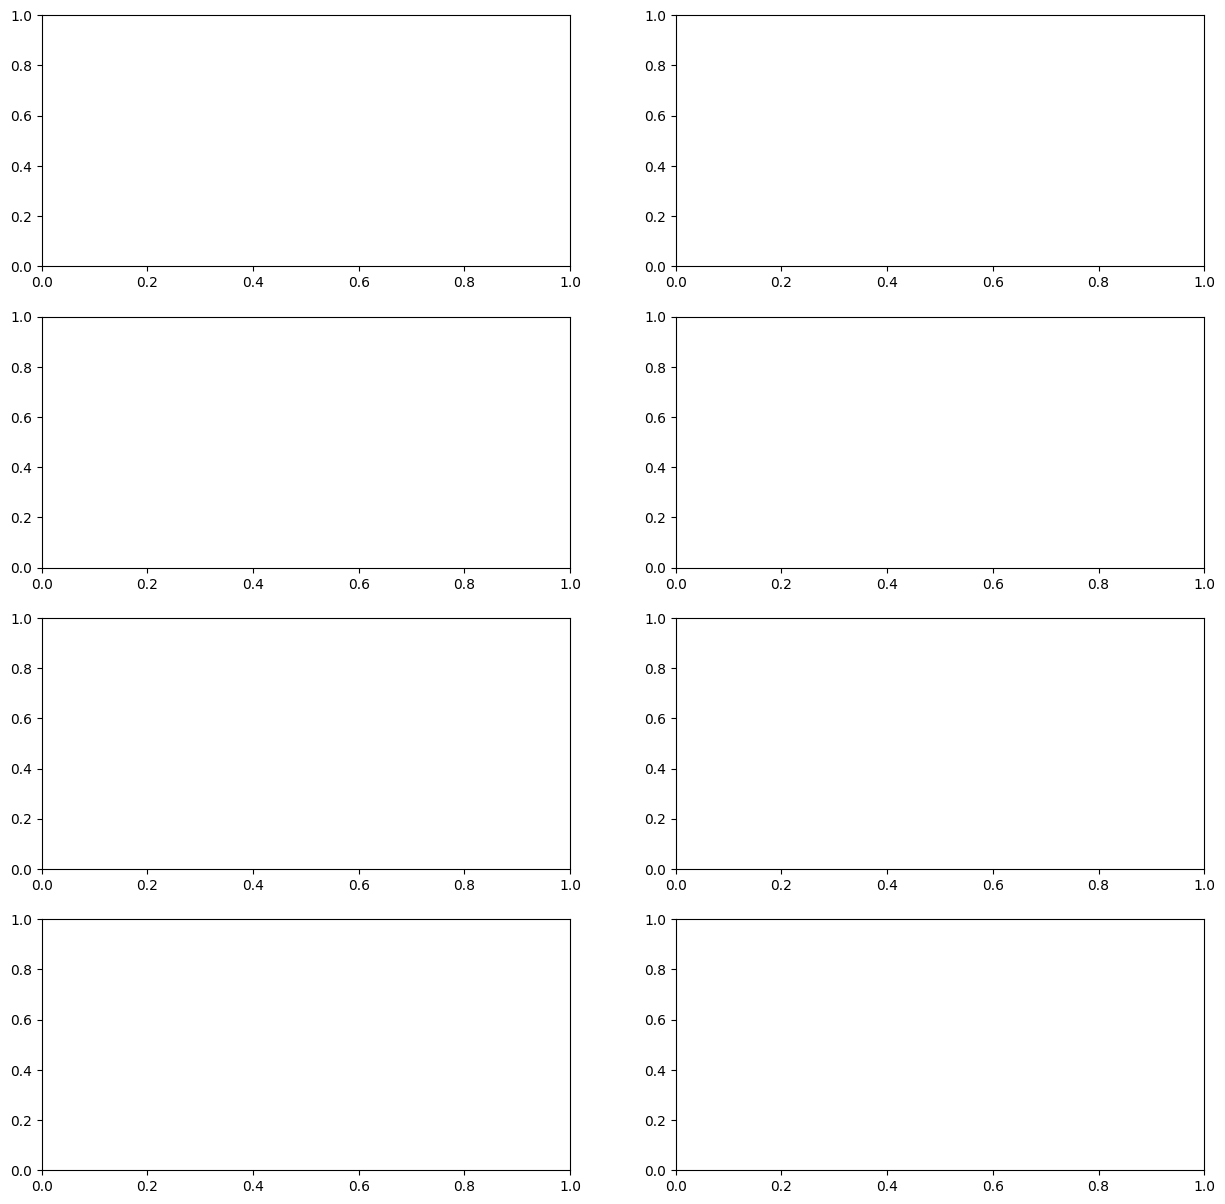

In [60]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

plt.subplot(4, 2, 1)
plt.plot(avg_box)
plt.title("Train Box Loss")

plt.subplot(4, 2, 2)
plt.plot(train_class_loss)
plt.title("Train Class Loss")

plt.subplot(4, 2, 3)
plt.plot(valid_precision)
plt.title("Validation Precision")

plt.subplot(4, 2, 4)
plt.plot(valid_recall)
plt.title("Validation Recall")

plt.subplot(4, 2, 5)
plt.plot(valid_mAP50)
plt.title("Validation mAP50")

plt.subplot(4, 2, 6)
plt.plot(valid_mAP50_95)
plt.title("Validation mAP50-95")

plt.subplot(4, 2, 7)
plt.plot(valid_box_loss)
plt.title("Validation Box Loss")

plt.subplot(4, 2, 8)
plt.plot(valid_class_loss)
plt.title("Validation Class Loss")

plt.suptitle("Training Metrics and Loss", fontsize=24)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

In [46]:
# import torch
# from tqdm import tqdm

# train_box_loss = []
# train_class_loss = []
# valid_precision = []
# valid_recall = []
# valid_mAP50 = []
# valid_mAP50_95 = []
# valid_box_loss = []
# valid_class_loss = []

# for epoch in range(10):
#     model.train()
#     total_train_box_loss = 0
#     total_train_class_loss = 0

#     train_loader_progress = tqdm(train_loader, desc=f"[Epoch {epoch+1}/10] Training", position=0, leave=True, dynamic_ncols=True, smoothing=0.3)
#     for images, targets in train_loader_progress:
#         images = [image.to(device) for image in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         outputs = model(images, targets)
#         loss_dict = outputs
#         losses = sum(loss for loss in loss_dict.values())

#         box_loss = loss_dict["loss_box_reg"].item()
#         cls_loss = loss_dict["loss_classifier"].item()

#         train_box_loss.append(box_loss)
#         train_class_loss.append(cls_loss)

#         total_train_box_loss += box_loss
#         total_train_class_loss += cls_loss

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         train_loader_progress.set_postfix({
#             'BoxLoss': f'{box_loss:.4f}',
#             'ClsLoss': f'{cls_loss:.4f}'
#         })

#     model.eval()
#     total_valid_box_loss = 0
#     total_valid_class_loss = 0

#     valid_loader_progress = tqdm(valid_loader, desc=f"[Epoch {epoch+1}/10] Validation", position=0, leave=True, dynamic_ncols=True, smoothing=0.3)
#     for images, targets in valid_loader_progress:
#         images = [image.to(device) for image in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         predicted_boxes = loss_dict["boxes"]
#         target_boxes = [t["boxes"] for t in targets]
#         giou_loss = GIOU(predicted_boxes, target_boxes)
#         losses += giou_loss

#         box_loss = loss_dict["loss_box_reg"].item()
#         cls_loss = loss_dict["loss_classifier"].item()

#         valid_box_loss.append(box_loss)
#         valid_class_loss.append(cls_loss)

#         total_valid_box_loss += box_loss
#         total_valid_class_loss += cls_loss

#         valid_loader_progress.set_postfix({
#             'BoxLoss': f'{box_loss:.4f}',
#             'ClsLoss': f'{cls_loss:.4f}'
#         })

#         precision = []
#         recall = []
#         AP50 = []
#         AP50_95 = []

#         with torch.no_grad():
#             outputs = model(images)

#         for i in range(len(targets)):
#             target = targets[i]
#             output = outputs[i]

#             pred_boxes = output["boxes"]
#             pred_scores = output["scores"]
#             pred_labels = output["labels"]

#             true_boxes = target["boxes"]
#             true_labels = target["labels"]

#             for label in range(4):
#                 true_boxes_label = true_boxes[true_labels == label]
#                 pred_boxes_label = pred_boxes[pred_labels == label]
#                 pred_scores_label = pred_scores[pred_labels == label]

#                 if len(true_boxes_label) == 0 or len(pred_boxes_label) == 0:
#                     precision.append(0)
#                     recall.append(0)
#                     AP50.append(0)
#                     AP50_95.append(0)
#                     continue

#                 iou = GIOU(true_boxes_label, pred_boxes_label)
#                 iou_thresholds = torch.linspace(0.5, 0.95, 10).to(device)

#                 true_positives = torch.zeros(len(iou_thresholds)).to(device)
#                 false_positives = torch.zeros(len(iou_thresholds)).to(device)
#                 false_negatives = torch.zeros(len(iou_thresholds)).to(device)

#                 for j, iou_threshold in enumerate(iou_thresholds):
#                     true_positives[j] = torch.sum(iou > iou_threshold)
#                     false_positives[j] = torch.sum(iou <= iou_threshold)
#                     false_negatives[j] = len(true_boxes_label) - true_positives[j]

#                 prec = true_positives / (true_positives + false_positives + 1e-6)
#                 rec = true_positives / (true_positives + false_negatives + 1e-6)

#                 precision.append(prec)
#                 recall.append(rec)
#                 AP50.append((prec * rec).mean())
#                 AP50_95.append((prec * rec).mean())

#         valid_precision.append(precision[-1])
#         valid_recall.append(recall[-1])
#         valid_mAP50.append(AP50[-1])
#         valid_mAP50_95.append(AP50_95[-1])

#     tqdm.write(f"Epoch {epoch+1}/10")
#     tqdm.write(f"Train Box Loss: {total_train_box_loss:.4f}, Class Loss: {total_train_class_loss:.4f}")
#     tqdm.write(f"Valid Box Loss: {total_valid_box_loss:.4f}, Class Loss: {total_valid_class_loss:.4f}")
#     if valid_mAP50:
#         tqdm.write(f"Valid mAP@0.5: {valid_mAP50[-1]:.4f}, mAP@0.5:0.95: {valid_mAP50_95[-1]:.4f}")
#     tqdm.write("-" * 50)


In [47]:
# import torch

# from torch.cuda.amp import autocast, GradScaler
# from torchmetrics.detection.mean_ap import MeanAveragePrecision
# from tqdm import tqdm

# def train_and_validate(
#     model,
#     optimizer,
#     train_loader,
#     valid_loader,
#     device,
#     num_epochs=10,
# ):
#     scaler = GradScaler()
#     metric = MeanAveragePrecision()

#     for epoch in range(num_epochs):
#         # ————————————— TRAIN —————————————
#         model.train()
#         running_box_loss = 0.0
#         running_cls_loss = 0.0

#         train_bar = tqdm(
#             train_loader,
#             desc=f"Epoch {epoch+1}/{num_epochs} [Train]",
#             unit="batch",
#             leave=False,
#         )
#         for images, targets in train_bar:
#             images = [img.to(device) for img in images]
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             optimizer.zero_grad()
#             with autocast():
#                 loss_dict = model(images, targets)
#                 # guard: make sure we actually got a dict
#                 if not isinstance(loss_dict, dict):
#                     raise RuntimeError(
#                         f"Expected a dict of losses, but got {type(loss_dict)}. "
#                         "Check that you always pass valid targets."
#                     )
#                 loss = sum(loss_dict.values())

#             # backward + step
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()

#             box_l = loss_dict["loss_box_reg"].item()
#             cls_l = loss_dict["loss_classifier"].item()
#             running_box_loss += box_l
#             running_cls_loss += cls_l

#             train_bar.set_postfix(Box=f"{box_l:.3f}", Cls=f"{cls_l:.3f}")

#         avg_train_box = running_box_loss / len(train_loader)
#         avg_train_cls = running_cls_loss / len(train_loader)

#         # ————————————— VALIDATION —————————————
#         model.eval()
#         metric.reset()
#         running_val_box = 0.0
#         running_val_cls = 0.0

#         valid_bar = tqdm(
#             valid_loader,
#             desc=f"Epoch {epoch+1}/{num_epochs} [Valid]",
#             unit="batch",
#             leave=False,
#         )
#         with torch.no_grad():
#             for images, targets in valid_bar:
#                 images = [img.to(device) for img in images]
#                 targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#                 # first forward: get losses
#                 with autocast():
#                     loss_dict = model(images, targets)
#                     if not isinstance(loss_dict, dict):
#                         raise RuntimeError(
#                             f"Expected a dict of losses, but got {type(loss_dict)}. "
#                             "Check that you always pass valid targets."
#                         )

#                 box_l = loss_dict["loss_box_reg"].item()
#                 cls_l = loss_dict["loss_classifier"].item()
#                 running_val_box += box_l
#                 running_val_cls += cls_l

#                 # second forward: get predictions for mAP
#                 with autocast():
#                     preds = model(images)

#                 metric.update(preds, targets)

#                 valid_bar.set_postfix(Box=f"{box_l:.3f}", Cls=f"{cls_l:.3f}")

#         avg_val_box = running_val_box / len(valid_loader)
#         avg_val_cls = running_val_cls / len(valid_loader)
#         stats = metric.compute()  # {'map_50': ..., 'map': ..., ...}

#         # ————————————— EPOCH SUMMARY —————————————
#         print(f"Epoch {epoch+1}/{num_epochs}")
#         print(f" ▶ Train Box Loss: {avg_train_box:.4f}, Cls Loss: {avg_train_cls:.4f}")
#         print(f" ▶ Val   Box Loss: {avg_val_box:.4f}, Cls Loss: {avg_val_cls:.4f}")
#         print(f" ▶ mAP@0.50: {stats['map_50']:.4f}, mAP@0.50:0.95: {stats['map']:.4f}")
#         print("-" * 60)
# train_and_validate(model, optimizer, train_loader, valid_loader, device, num_epochs=10)

import torch
from torch.cuda.amp import autocast, GradScaler
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
import torch
from torch.cuda.amp import autocast, GradScaler
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

def train_and_validate(
    model,
    optimizer,
    train_loader,
    valid_loader,
    device,
    num_epochs=10,
):
    scaler = GradScaler()
    metric = MeanAveragePrecision()

    for epoch in range(num_epochs):
        # —————————— TRAIN ——————————
        model.train()
        running_box = running_cls = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", unit="batch")
        
        for images, targets in train_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            with autocast():
                loss_dict = model(images, targets)
                if not isinstance(loss_dict, dict):
                    raise RuntimeError(f"Expected loss dict in train, got {type(loss_dict)}")
                loss = sum(loss_dict.values())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            box_l = loss_dict["loss_box_reg"].item()
            cls_l = loss_dict["loss_classifier"].item()
            running_box += box_l
            running_cls += cls_l

            train_bar.set_postfix(Box=f"{box_l:.3f}", Cls=f"{cls_l:.3f}")

        avg_box = running_box / len(train_loader)
        avg_cls = running_cls / len(train_loader)

        # ——— VALIDATION LOSS ———
        # We need the model in train mode so model(images, targets) returns losses
        model.train()
        running_vbox = running_vcls = 0.0
        val_loss_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val-Loss]", unit="batch")
        with torch.no_grad():
            for images, targets in val_loss_bar:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                with autocast():
                    vloss_dict = model(images, targets)
                    if not isinstance(vloss_dict, dict):
                        raise RuntimeError(f"Expected loss dict in val-loss, got {type(vloss_dict)}")

                vbox_l = vloss_dict["loss_box_reg"].item()
                vcls_l = vloss_dict["loss_classifier"].item()
                running_vbox += vbox_l
                running_vcls += vcls_l

                val_loss_bar.set_postfix(VBox=f"{vbox_l:.3f}", VCls=f"{vcls_l:.3f}")

        avg_vbox = running_vbox / len(valid_loader)
        avg_vcls = running_vcls / len(valid_loader)

        # ——— VALIDATION METRICS (mAP) ———
        model.eval()
        metric.reset()
        val_map_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val-mAP]", unit="batch")
        with torch.no_grad():
            for images, targets in val_map_bar:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                preds = model(images)  # now returns a list of preds
                metric.update(preds, targets)

        stats = metric.compute()  # e.g. {'map_50': ..., 'map': ...}

        # —————————— EPOCH SUMMARY ——————————
        print(f"\nEpoch {epoch+1}/{num_epochs} summary:")
        print(f" ▶ Train   Box Loss: {avg_box:.4f}, Cls Loss: {avg_cls:.4f}")
        print(f" ▶ Val-Loss Box Loss: {avg_vbox:.4f}, Cls Loss: {avg_vcls:.4f}")
        print(f" ▶ mAP@0.50: {stats['map_50']:.4f}, mAP@0.50:0.95: {stats['map']:.4f}")
        print("-" * 60)


train_and_validate(model, optimizer, train_loader, valid_loader, device, num_epochs=10)

C:\Users\Hariom Meena\AppData\Local\Temp\ipykernel_22052\1973135367.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10 [Train]:   0%|          | 0/582 [00:00<?, ?batch/s]C:\Users\Hariom Meena\AppData\Local\Temp\ipykernel_22052\1973135367.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10 [Val-Loss]:   0%|          | 0/223 [00:00<?, ?batch/s]C:\Users\Hariom Meena\AppData\Local\Temp\ipykernel_22052\1973135367.py:172: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10 [Val-mAP]: 100%|██████████| 223/223 [15:43<00:00,  4.23s/batch]



Epoch 1/10 summary:
 ▶ Train   Box Loss: 0.1148, Cls Loss: 0.1511
 ▶ Val-Loss Box Loss: 0.1610, Cls Loss: 0.1315
 ▶ mAP@0.50: 0.2116, mAP@0.50:0.95: 0.0861
------------------------------------------------------------


Epoch 2/10 [Val-mAP]: 100%|██████████| 223/223 [59:59<00:00, 16.14s/batch]   



Epoch 2/10 summary:
 ▶ Train   Box Loss: 0.1552, Cls Loss: 0.1041
 ▶ Val-Loss Box Loss: 0.1558, Cls Loss: 0.1000
 ▶ mAP@0.50: 0.3347, mAP@0.50:0.95: 0.1681
------------------------------------------------------------


Epoch 3/10 [Val-mAP]: 100%|██████████| 223/223 [26:31<00:00,  7.14s/batch]



Epoch 3/10 summary:
 ▶ Train   Box Loss: 0.1533, Cls Loss: 0.0920
 ▶ Val-Loss Box Loss: 0.1527, Cls Loss: 0.0895
 ▶ mAP@0.50: 0.3938, mAP@0.50:0.95: 0.2132
------------------------------------------------------------


Epoch 4/10 [Val-mAP]: 100%|██████████| 223/223 [26:07<00:00,  7.03s/batch]



Epoch 4/10 summary:
 ▶ Train   Box Loss: 0.1431, Cls Loss: 0.0828
 ▶ Val-Loss Box Loss: 0.1488, Cls Loss: 0.0869
 ▶ mAP@0.50: 0.4232, mAP@0.50:0.95: 0.2336
------------------------------------------------------------


Epoch 5/10 [Val-mAP]: 100%|██████████| 223/223 [26:29<00:00,  7.13s/batch]



Epoch 5/10 summary:
 ▶ Train   Box Loss: 0.1377, Cls Loss: 0.0767
 ▶ Val-Loss Box Loss: 0.1445, Cls Loss: 0.0820
 ▶ mAP@0.50: 0.4568, mAP@0.50:0.95: 0.2564
------------------------------------------------------------


Epoch 6/10 [Val-mAP]: 100%|██████████| 223/223 [25:52<00:00,  6.96s/batch]



Epoch 6/10 summary:
 ▶ Train   Box Loss: 0.1298, Cls Loss: 0.0714
 ▶ Val-Loss Box Loss: 0.1340, Cls Loss: 0.0790
 ▶ mAP@0.50: 0.4828, mAP@0.50:0.95: 0.2864
------------------------------------------------------------


Epoch 7/10 [Val-mAP]: 100%|██████████| 223/223 [26:11<00:00,  7.05s/batch]



Epoch 7/10 summary:
 ▶ Train   Box Loss: 0.1227, Cls Loss: 0.0664
 ▶ Val-Loss Box Loss: 0.1506, Cls Loss: 0.0753
 ▶ mAP@0.50: 0.4976, mAP@0.50:0.95: 0.2836
------------------------------------------------------------


Epoch 8/10 [Val-mAP]: 100%|██████████| 223/223 [25:52<00:00,  6.96s/batch]



Epoch 8/10 summary:
 ▶ Train   Box Loss: 0.1167, Cls Loss: 0.0613
 ▶ Val-Loss Box Loss: 0.1305, Cls Loss: 0.0727
 ▶ mAP@0.50: 0.5087, mAP@0.50:0.95: 0.3067
------------------------------------------------------------


Epoch 9/10 [Val-mAP]: 100%|██████████| 223/223 [25:34<00:00,  6.88s/batch]



Epoch 9/10 summary:
 ▶ Train   Box Loss: 0.1106, Cls Loss: 0.0580
 ▶ Val-Loss Box Loss: 0.1199, Cls Loss: 0.0699
 ▶ mAP@0.50: 0.5258, mAP@0.50:0.95: 0.3239
------------------------------------------------------------


Epoch 10/10 [Val-mAP]: 100%|██████████| 223/223 [25:39<00:00,  6.90s/batch]



Epoch 10/10 summary:
 ▶ Train   Box Loss: 0.1072, Cls Loss: 0.0548
 ▶ Val-Loss Box Loss: 0.1244, Cls Loss: 0.0736
 ▶ mAP@0.50: 0.5313, mAP@0.50:0.95: 0.3206
------------------------------------------------------------


In [53]:
# Save only the model weights
torch.save(model.state_dict(), 'fasterrcnn_model_weights.pth')


In [55]:
import os
print(os.path.exists('fasterrcnn_model_weights.pth'))  # should return True


True


In [66]:
test_dataset = create_valid_dataset(
    TEST_IMAGES,
    TEST_LABELS,
    (640, 640),
    classes,
    
)

test_loader = create_valid_loader(test_dataset, batch_size=1, num_workers=0)

Image count: 1111
Label count: 1111


In [73]:
import os
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Evaluation directory
OUTPUT_DIR = "evaluation_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Move model to eval mode
model.eval()

# Initialize metric calculator
metric = MeanAveragePrecision(class_metrics=True)

# Store metrics over dataset
CONFIDENCE_THRESHOLD = 0.5  # Set your desired threshold
num = 0

all_labels = []
all_scores = []

for images, targets in test_loader:
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        outputs = model(images)

    # Update mAP metric
    metric.update(outputs, targets)

    # Collect labels and scores for Precision-Recall
    for i in range(len(images)):
        for label, score in zip(outputs[i]["labels"], outputs[i]["scores"]):
            if score >= CONFIDENCE_THRESHOLD:
                all_labels.append(label.item())
                all_scores.append(score.item())

# Compute metrics
metrics = metric.compute()

# Print metrics
print("Evaluation Metrics:")
for k, v in metrics.items():
    if isinstance(v, torch.Tensor):
        if v.numel() == 1:
            print(f"{k}: {v.item():.4f}")
        else:
            print(f"{k}: {v.cpu().numpy()}")
    else:
        print(f"{k}: {v}")

# Save metrics to file
with open(os.path.join(OUTPUT_DIR, "metrics.txt"), "w") as f:
    for k, v in metrics.items():
        if isinstance(v, torch.Tensor):
            if v.numel() == 1:
                f.write(f"{k}: {v.item():.4f}\n")
            else:
                f.write(f"{k}: {v.cpu().numpy()}\n")
        else:
            f.write(f"{k}: {v}\n")

# Plot Precision-Recall curve for each class
precision, recall, _ = precision_recall_curve(all_labels, all_scores)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.grid(True)

# Save the Precision-Recall curve plot
plt.savefig(os.path.join(OUTPUT_DIR, "precision_recall_curve.png"))
plt.close()

# OPTIONAL: Plot Precision-Recall curve per class (if needed)
if "map_per_class" in metrics:
    pr_per_class = metrics["map_per_class"]
    if pr_per_class is not None and isinstance(pr_per_class, torch.Tensor):
        plt.plot(pr_per_class.cpu().numpy(), label="mAP per class")
        plt.xlabel("Class ID")
        plt.ylabel("mAP")
        plt.title("mAP per class")
        plt.legend()
        plt.grid()
        plt.savefig(os.path.join(OUTPUT_DIR, "map_per_class.png"))
        plt.close()


Evaluation Metrics:
map: 0.3075
map_50: 0.5057
map_75: 0.3297
map_small: 0.1026
map_medium: 0.3579
map_large: 0.4190
mar_1: 0.1115
mar_10: 0.3414
mar_100: 0.3825
mar_small: 0.1442
mar_medium: 0.4402
mar_large: 0.4825
map_per_class: [0.         0.54568785 0.19358154 0.49092668]
mar_100_per_class: [0.         0.6057631  0.3626728  0.56138617]
classes: [0 1 2 3]


ValueError: multiclass format is not supported

In [78]:
import os
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# ——— Setup ———
OUTPUT_DIR = "evaluation_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
model.eval()

# ——— Two metrics: one at IoU=0.5, one at default [0.5:0.95] ———
metric50   = MeanAveragePrecision(class_metrics=True,   iou_thresholds=[0.5])
metric5095 = MeanAveragePrecision(class_metrics=True)   # defaults to [0.5,0.55,…,0.95]

# ——— Run evaluation ———
for images, targets in test_loader:
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    with torch.no_grad():
        outputs = model(images)
    metric50.update(outputs, targets)
    metric5095.update(outputs, targets)

# ——— Compute metrics ———
metrics50   = metric50.compute()    # only IoU=0.5
metrics5095 = metric5095.compute()  # IoU=0.5→0.95 averaged

# ——— Extract per-class tensors ———
map50_pc   = metrics50["map_per_class"]   # shape [num_classes]
map5095_pc = metrics5095["map_per_class"] # shape [num_classes]

# ——— Print & Save full raw metrics for reference ———
with open(os.path.join(OUTPUT_DIR, "metrics_full.txt"), "w") as f:
    for label, m in [("mAP@0.5", metrics50), ("mAP@0.5:0.95", metrics5095)]:
        f.write(f"--- {label} ---\n")
        for k, v in m.items():
            if isinstance(v, torch.Tensor):
                val = v.item() if v.numel()==1 else v.cpu().numpy().tolist()
            else:
                val = v
            f.write(f"{k}: {val}\n")
        f.write("\n")

# ——— Print & Save per-class results ———
with open(os.path.join(OUTPUT_DIR, "mAP_per_class.txt"), "w") as f:
    print("\nmAP@0.5 per class:")
    f.write("mAP@0.5 per class:\n")
    for cid, score in enumerate(map50_pc):
        line = f"Class {cid}: {score.item():.4f}"
        print(line); f.write(line + "\n")

    print("\nmAP@0.5:0.95 per class:")
    f.write("\nmAP@0.5:0.95 per class:\n")
    for cid, score in enumerate(map5095_pc):
        line = f"Class {cid}: {score.item():.4f}"
        print(line); f.write(line + "\n")



mAP@0.5 per class:
Class 0: 0.0000
Class 1: 0.7988
Class 2: 0.4023
Class 3: 0.8219

mAP@0.5:0.95 per class:
Class 0: 0.0000
Class 1: 0.5457
Class 2: 0.1936
Class 3: 0.4909


In [80]:
import os
import torch
import matplotlib.pyplot as plt
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# ——— Setup ———
OUTPUT_DIR = "evaluation_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
model.eval()

# ——— Two metrics: IoU=0.5 only, and IoU=0.5→0.95 avg ———
metric50   = MeanAveragePrecision(class_metrics=True, iou_thresholds=[0.5])
metric5095 = MeanAveragePrecision(class_metrics=True)  # default [0.5,0.55,…,0.95]

# ——— Determine how many batches to run (50% of test_loader) ———
total_batches = len(test_loader)
half_batches  = total_batches // 2

# ——— Run evaluation on just the first half of test_loader ———
for batch_idx, (images, targets) in enumerate(test_loader):
    if batch_idx >= half_batches:
        break

    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    with torch.no_grad():
        outputs = model(images)

    metric50.update(outputs, targets)
    metric5095.update(outputs, targets)

# ——— Compute metrics ———
metrics50   = metric50.compute()    # mAP@0.5
metrics5095 = metric5095.compute()  # mAP@[0.5:0.95] avg

# ——— Extract per-class results ———
map50_pc   = metrics50["map_per_class"]   # 1-D tensor [num_classes]
map5095_pc = metrics5095["map_per_class"] # 1-D tensor [num_classes]

# ——— Save full raw metrics ———
with open(os.path.join(OUTPUT_DIR, "metrics_full.txt"), "w") as f:
    for label, m in [("mAP@0.5", metrics50), ("mAP@0.5:0.95", metrics5095)]:
        f.write(f"--- {label} ---\n")
        for k, v in m.items():
            if isinstance(v, torch.Tensor):
                val = v.item() if v.numel()==1 else v.cpu().numpy().tolist()
            else:
                val = v
            f.write(f"{k}: {val}\n")
        f.write("\n")

# ——— Save and print per-class numbers ———
with open(os.path.join(OUTPUT_DIR, "mAP_per_class.txt"), "w") as f:
    f.write("mAP@0.5 per class:\n")
    for cid, score in enumerate(map50_pc):
        f.write(f"Class {cid}: {score.item():.4f}\n")
    f.write("\nmAP@0.5:0.95 per class:\n")
    for cid, score in enumerate(map5095_pc):
        f.write(f"Class {cid}: {score.item():.4f}\n")

print("mAP@0.5 per class:")
for cid, score in enumerate(map50_pc):
    print(f"Class {cid}: {score.item():.4f}")
print("\nmAP@0.5:0.95 per class:")
for cid, score in enumerate(map5095_pc):
    print(f"Class {cid}: {score.item():.4f}")

# ——— Plot & save bar chart for mAP@0.5 ———
classes      = list(range(map50_pc.shape[0]))
map50_vals   = [s.item() for s in map50_pc]

plt.figure()
plt.bar(classes, map50_vals)
plt.xlabel("Class ID")
plt.ylabel("mAP@0.5")
plt.title("Per-Class mAP@0.5")
plt.xticks(classes)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "map50_per_class.png"))
plt.close()

# ——— Plot & save bar chart for mAP@0.5:0.95 ———
map5095_vals = [s.item() for s in map5095_pc]

plt.figure()
plt.bar(classes, map5095_vals)
plt.xlabel("Class ID")
plt.ylabel("mAP@0.5:0.95")
plt.title("Per-Class mAP@0.5:0.95")
plt.xticks(classes)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "map50_95_per_class.png"))
plt.close()


mAP@0.5 per class:
Class 0: 0.0000
Class 1: 0.7949
Class 2: 0.4317
Class 3: 0.7985

mAP@0.5:0.95 per class:
Class 0: 0.0000
Class 1: 0.5486
Class 2: 0.1969
Class 3: 0.4865


In [82]:
import os
import torch
import matplotlib.pyplot as plt
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

# ——— Setup ———
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR = "evaluation_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)
model.eval()

# ——— Evaluation metric (mAP@0.5 and 0.5:0.95 combined) ———
metric = MeanAveragePrecision()
metric.to(device)

# ——— Only use 50% of the test data ———
half_test_data = len(test_loader) // 10
test_iter = iter(test_loader)

print("Evaluating on 50% of test data...")
for _ in tqdm(range(half_test_data)):
    images, targets = next(test_iter)
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    with torch.no_grad():
        outputs = model(images)
    metric.update(outputs, targets)

# ——— Compute metrics ———
metrics = metric.compute()

# ——— Save core metrics ———
with open(os.path.join(OUTPUT_DIR, "metrics_summary.txt"), "w") as f:
    for k, v in metrics.items():
        if isinstance(v, torch.Tensor):
            val = v.item() if v.numel() == 1 else v.cpu().numpy().tolist()
        else:
            val = v
        f.write(f"{k}: {val}\n")
        print(f"{k}: {val}")

# ——— Plot PR Curve (Precision vs Recall) ———
# We'll create this manually using collected values
if 'precision_recall_curve' in metric.__dir__():
    pr_curves = metric.precision_recall_curve()
    precisions = pr_curves["precision"].cpu().numpy()
    recalls = pr_curves["recall"].cpu().numpy()

    plt.figure()
    plt.plot(recalls, precisions, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (PR)")
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_DIR, "pr_curve.png"))
    plt.close()
else:
    print("\n[Warning] PR curve generation not supported by current torchmetrics version.")



Evaluating on 50% of test data...


  0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 111/111 [03:10<00:00,  1.71s/it]


map: 0.28357309103012085
map_50: 0.4393640160560608
map_75: 0.32711005210876465
map_small: 0.12810847163200378
map_medium: 0.33169397711753845
map_large: 0.43209975957870483
mar_1: 0.12031914293766022
mar_10: 0.3260807991027832
mar_100: 0.35826271772384644
mar_small: 0.15931354463100433
mar_medium: 0.4194425940513611
mar_large: 0.44333332777023315
map_per_class: -1.0
mar_100_per_class: -1.0
classes: [0, 1, 2, 3]

[Warning] PR curve generation not supported by current torchmetrics version.


In [89]:
import os
import torch
import matplotlib.pyplot as plt
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.utils.data import Subset, DataLoader
from torchvision.ops import box_iou
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, average_precision_score

# ——— Setup ———
OUTPUT_DIR = "evaluation_graphs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ——— Use 50% of the test dataset ———
half_len = len(test_loader.dataset) 
subset_dataset = Subset(test_loader.dataset, list(range(half_len)))
subset_loader  = DataLoader(
    subset_dataset,
    batch_size=test_loader.batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=test_loader.collate_fn
)

# ——— 1) Compute mAP metrics ———
metric50   = MeanAveragePrecision(class_metrics=False, iou_thresholds=[0.5])
metric5095 = MeanAveragePrecision(class_metrics=False)  # default [0.5,...,0.95]

print("Evaluating mAP on 50% of test data...")
for images, targets in tqdm(subset_loader):
    imgs = [img.to(device) for img in images]
    tars = [{k: v.to(device) for k, v in t.items()} for t in targets]
    with torch.no_grad():
        outputs = model(imgs)
    metric50.update(outputs, tars)
    metric5095.update(outputs, tars)

res50   = metric50.compute()
res5095 = metric5095.compute()

map50   = res50["map"].item()
map5095 = res5095["map"].item()

# ——— Save mAP results ———
with open(os.path.join(OUTPUT_DIR, "map_results.txt"), "w") as f:
    f.write(f"mAP@0.5     : {map50:.4f}\n")
    f.write(f"mAP@[0.5:0.95]: {map5095:.4f}\n")
print(f"mAP@0.5     : {map50:.4f}")
print(f"mAP@[0.5:0.95]: {map5095:.4f}")

# ——— Bar chart for mAP comparison ———
plt.figure()
plt.bar(["mAP@0.5", "mAP@[0.5:0.95]"], [map50, map5095], width=0.4)
plt.ylim(0, 1)
plt.ylabel("mAP")
plt.title("Overall mAP Comparison")
for i, v in enumerate([map50, map5095]):
    plt.text(i, v + 0.02, f"{v:.3f}", ha="center")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "mAP_comparison.png"))
plt.close()

# ——— 2) Build detection‐level TP/FP for PR curve at IoU=0.5 ———
all_scores = []
all_labels = []  # 1 for TP, 0 for FP

print("Collecting predictions for PR curve...")
for images, targets in tqdm(subset_loader):
    imgs = [img.to(device) for img in images]
    tars = [{k: v.to(device) for k, v in t.items()} for t in targets]
    with torch.no_grad():
        outputs = model(imgs)

    # per-image matching
    for out, tar in zip(outputs, tars):
        pred_boxes  = out["boxes"].cpu()
        pred_scores = out["scores"].cpu()
        pred_labels = out["labels"].cpu()
        gt_boxes    = tar["boxes"].cpu()
        gt_labels   = tar["labels"].cpu()

        # sort by score descending
        order = torch.argsort(pred_scores, descending=True)
        pred_boxes  = pred_boxes[order]
        pred_scores = pred_scores[order]
        pred_labels = pred_labels[order]

        matched_gt = torch.zeros(len(gt_boxes), dtype=torch.bool)

        for pb, ps, pl in zip(pred_boxes, pred_scores, pred_labels):
            # find GT of same class
            mask = gt_labels == pl
            if not mask.any():
                all_scores.append(ps.item()); all_labels.append(0)
                continue

            # compute IoUs
            ious = box_iou(pb.unsqueeze(0), gt_boxes[mask])
            max_iou, idx = ious[0].max(0)
            if max_iou >= 0.5:
                # get index in original gt_boxes
                gt_idx = torch.nonzero(mask)[idx]
                if not matched_gt[gt_idx]:
                    all_scores.append(ps.item()); all_labels.append(1)
                    matched_gt[gt_idx] = True
                else:
                    # duplicate detection → false positive
                    all_scores.append(ps.item()); all_labels.append(0)
            else:
                all_scores.append(ps.item()); all_labels.append(0)

# convert to numpy
import numpy as np
y_scores = np.array(all_scores)
y_true   = np.array(all_labels)

# compute sklearn PR curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)

# ——— Plot PR curve ———
plt.figure()
plt.plot(recall, precision, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve @ IoU=0.5")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "pr_curve.png"))
plt.close()

# ——— Plot Precision vs Threshold ———
plt.figure()
plt.plot(thresholds, precision[:-1])
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision vs Threshold")
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "precision_vs_threshold.png"))
plt.close()

# ——— Plot Recall vs Threshold ———
plt.figure()
plt.plot(thresholds, recall[:-1])
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall vs Threshold")
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "recall_vs_threshold.png"))
plt.close()

print("✅ All metrics and curves saved in", OUTPUT_DIR)


Evaluating mAP on 50% of test data...


100%|██████████| 1111/1111 [30:59<00:00,  1.67s/it]


mAP@0.5     : 0.5057
mAP@[0.5:0.95]: 0.3075


100%|██████████| 1111/1111 [31:08<00:00,  1.68s/it]


✅ All metrics and curves saved in evaluation_graphs


In [48]:
# ##this was final code that working


# import torch
# from tqdm import tqdm

# train_box_loss = []
# train_class_loss = []
# valid_precision = []
# valid_recall = []
# valid_mAP50 = []
# valid_mAP50_95 = []
# valid_box_loss = []
# valid_class_loss = []

# for epoch in range(10):
#     model.train()
#     total_train_box_loss = 0
#     total_train_class_loss = 0

#     for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
#         images = [image.to(device) for image in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         outputs = model(images, targets)
#         loss_dict = outputs
#         losses = sum(loss for loss in loss_dict.values())

#         train_box_loss.append(loss_dict["loss_box_reg"].item())
#         train_class_loss.append(loss_dict["loss_classifier"].item())

#         total_train_box_loss += loss_dict["loss_box_reg"].item()
#         total_train_class_loss += loss_dict["loss_classifier"].item()

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#     model.eval()
#     total_valid_box_loss = 0
#     total_valid_class_loss = 0

#     for images, targets in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}"):
#         images = [image.to(device) for image in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         predicted_boxes = loss_dict["boxes"]
#         target_boxes = [t["boxes"] for t in targets]
#         giou_loss = GIOU(predicted_boxes, target_boxes)
#         losses += giou_loss

#         valid_box_loss.append(loss_dict["loss_box_reg"].item())
#         valid_class_loss.append(loss_dict["loss_classifier"].item())

#         total_valid_box_loss += loss_dict["loss_box_reg"].item()
#         total_valid_class_loss += loss_dict["loss_classifier"].item()

#         precision = []
#         recall = []
#         AP50 = []
#         AP50_95 = []

#         with torch.no_grad():
#             outputs = model(images)

#         for i in range(len(targets)):
#             target = targets[i]
#             output = outputs[i]

#             pred_boxes = output["boxes"]
#             pred_scores = output["scores"]
#             pred_labels = output["labels"]

#             true_boxes = target["boxes"]
#             true_labels = target["labels"]

#             for label in range(7):
#                 true_boxes_label = true_boxes[true_labels == label]
#                 pred_boxes_label = pred_boxes[pred_labels == label]
#                 pred_scores_label = pred_scores[pred_labels == label]

#                 if len(true_boxes_label) == 0 or len(pred_boxes_label) == 0:
#                     precision.append(0)
#                     recall.append(0)
#                     AP50.append(0)
#                     AP50_95.append(0)
#                     continue

#                 iou = GIOU(true_boxes_label, pred_boxes_label)
#                 iou_thresholds = torch.linspace(0.5, 0.95, 10).to(device)

#                 true_positives = torch.zeros(len(iou_thresholds)).to(device)
#                 false_positives = torch.zeros(len(iou_thresholds)).to(device)
#                 false_negatives = torch.zeros(len(iou_thresholds)).to(device)

#                 for j, iou_threshold in enumerate(iou_thresholds):
#                     true_positives[j] = torch.sum(iou > iou_threshold)
#                     false_positives[j] = torch.sum(iou <= iou_threshold)
#                     false_negatives[j] = len(true_boxes_label) - true_positives[j]

#                 precision.append(true_positives / (true_positives + false_positives + 1e-6))
#                 recall.append(true_positives / (true_positives + false_negatives + 1e-6))
#                 AP50.append((precision[-1] * recall[-1]).mean())
#                 AP50_95.append((precision[-1] * recall[-1]).mean())

#         valid_precision.append(precision[-1])
#         valid_recall.append(recall[-1])
#         valid_mAP50.append(AP50[-1])
#         valid_mAP50_95.append(AP50_95[-1])

#     print(f"Epoch {epoch+1}/10")
#     print(f"Train Box Loss: {total_train_box_loss:.4f}, Class Loss: {total_train_class_loss:.4f}")
#     print(f"Valid Box Loss: {total_valid_box_loss:.4f}, Class Loss: {total_valid_class_loss:.4f}")
#     if valid_mAP50:
#         print(f"Valid mAP@0.5: {valid_mAP50[-1]:.4f}, mAP@0.5:0.95: {valid_mAP50_95[-1]:.4f}")
#     print("-" * 50)


In [49]:
# import torch
# from tqdm import tqdm

# train_box_loss = []
# train_class_loss = []
# valid_precision = []
# valid_recall = []
# valid_mAP50 = []
# valid_mAP50_95 = []
# valid_box_loss = []
# valid_class_loss = []

# for epoch in range(10):
#     model.train()
#     total_train_box_loss = 0
#     total_train_class_loss = 0

#     for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
#         images = [image.to(device) for image in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         outputs = model(images, targets)
#         loss_dict = outputs
#         losses = sum(loss for loss in loss_dict.values())

#         train_box_loss.append(loss_dict["loss_box_reg"].item())
#         train_class_loss.append(loss_dict["loss_classifier"].item())

#         total_train_box_loss += loss_dict["loss_box_reg"].item()
#         total_train_class_loss += loss_dict["loss_classifier"].item()

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#     model.eval()
#     total_valid_box_loss = 0
#     total_valid_class_loss = 0

#     for images, targets in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}"):
#         images = [image.to(device) for image in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         predicted_boxes = loss_dict["boxes"]
#         target_boxes = [t["boxes"] for t in targets]
#         giou_loss = GIOU(predicted_boxes, target_boxes)
#         losses += giou_loss

#         valid_box_loss.append(loss_dict["loss_box_reg"].item())
#         valid_class_loss.append(loss_dict["loss_classifier"].item())

#         total_valid_box_loss += loss_dict["loss_box_reg"].item()
#         total_valid_class_loss += loss_dict["loss_classifier"].item()

#         precision = []
#         recall = []
#         AP50 = []
#         AP50_95 = []

#         with torch.no_grad():
#             outputs = model(images)

#         for i in range(len(targets)):
#             target = targets[i]
#             output = outputs[i]

#             pred_boxes = output["boxes"]
#             pred_scores = output["scores"]
#             pred_labels = output["labels"]

#             true_boxes = target["boxes"]
#             true_labels = target["labels"]

#             for label in range(7):
#                 true_boxes_label = true_boxes[true_labels == label]
#                 pred_boxes_label = pred_boxes[pred_labels == label]
#                 pred_scores_label = pred_scores[pred_labels == label]

#                 if len(true_boxes_label) == 0 or len(pred_boxes_label) == 0:
#                     precision.append(0)
#                     recall.append(0)
#                     AP50.append(0)
#                     AP50_95.append(0)
#                     continue

#                 iou = GIOU(true_boxes_label, pred_boxes_label)
#                 iou_thresholds = torch.linspace(0.5, 0.95, 10).to(device)

#                 true_positives = torch.zeros(len(iou_thresholds)).to(device)
#                 false_positives = torch.zeros(len(iou_thresholds)).to(device)
#                 false_negatives = torch.zeros(len(iou_thresholds)).to(device)

#                 for j, iou_threshold in enumerate(iou_thresholds):
#                     true_positives[j] = torch.sum(iou > iou_threshold)
#                     false_positives[j] = torch.sum(iou <= iou_threshold)
#                     false_negatives[j] = len(true_boxes_label) - true_positives[j]

#                 precision.append(true_positives / (true_positives + false_positives + 1e-6))
#                 recall.append(true_positives / (true_positives + false_negatives + 1e-6))
#                 AP50.append((precision[-1] * recall[-1]).mean())
#                 AP50_95.append((precision[-1] * recall[-1]).mean())

#         valid_precision.append(precision[-1])
#         valid_recall.append(recall[-1])
#         valid_mAP50.append(AP50[-1])
#         valid_mAP50_95.append(AP50_95[-1])

#     print(f"Epoch {epoch+1}/10")
#     print(f"Train Box Loss: {total_train_box_loss:.4f}, Class Loss: {total_train_class_loss:.4f}")
#     print(f"Valid Box Loss: {total_valid_box_loss:.4f}, Class Loss: {total_valid_class_loss:.4f}")
#     if valid_mAP50:
#         print(f"Valid mAP@0.5: {valid_mAP50[-1]:.4f}, mAP@0.5:0.95: {valid_mAP50_95[-1]:.4f}")
#     print("-" * 50)


In [50]:
# #this was working




# train_box_loss = []
# train_class_loss = []
# valid_precision = []
# valid_recall = []
# valid_mAP50 = []
# valid_mAP50_95 = []
# valid_box_loss = []
# valid_class_loss = []

# for epoch in range(10):

#     model.train()
#     # Assume you have a data loader that provides images and targets (bounding boxes and labels)
#     for images, targets in train_loader:
#     # Ensure that the images and targets are sent to the correct device (CPU or GPU)
#         images = [image.to(device) for image in images]  # Assuming images is a list
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Sending targets to device

#     # Forward pass through the model
#         outputs = model(images, targets)  # targets are now passed

#     # Now you can calculate losses or use the predictions from outputs
#         loss_dict = outputs
#         losses = sum(loss for loss in loss_dict.values())
#     # Perform the rest of your training steps


# # Sum the losses from the model output (if necessary)
#         losses = sum(loss for loss in loss_dict.values())
        
#         train_box_loss.append(loss_dict["loss_box_reg"].item())
#         train_class_loss.append(loss_dict["loss_classifier"].item())
        
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#     model.eval()
#     for images, targets in valid_loader:
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         predicted_boxes = loss_dict["boxes"]
#         target_boxes = [t["boxes"] for t in targets]
#         giou_loss = GIOU(predicted_boxes, target_boxes)
#         losses += giou_loss
        
#         valid_box_loss.append(loss_dict["loss_box_reg"].item())
#         valid_class_loss.append(loss_dict["loss_classifier"].item())
        
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
#         precision = []
#         recall = []
#         AP50 = []
#         AP50_95 = []
        
#         with torch.no_grad():
#             outputs = model(images)
            
#         for i in range(len(targets)):
#             target = targets[i]
#             output = outputs[i]
            
#             pred_boxes = output["boxes"]
#             pred_scores = output["scores"]
#             pred_labels = output["labels"]
            
#             true_boxes = target["boxes"]
#             true_labels = target["labels"]
            
#             for label in range(7):
#                 true_boxes_label = true_boxes[true_labels == label]
#                 pred_boxes_label = pred_boxes[pred_labels == label]
#                 pred_scores_label = pred_scores[pred_labels == label]
                
#                 if len(true_boxes_label) == 0:
#                     precision.append(0)
#                     recall.append(0)
#                     AP50.append(0)
#                     AP50_95.append(0)
#                     continue
                
#                 if len(pred_boxes_label) == 0:
#                     precision.append(0)
#                     recall.append(0)
#                     AP50.append(0)
#                     AP50_95.append(0)
#                     continue
                
#                 iou = GIOU(true_boxes_label, pred_boxes_label)
#                 iou_thresholds = torch.linspace(0.5, 0.95, 10).to(device)
                
#                 true_positives = torch.zeros(len(iou_thresholds)).to(device)
#                 false_positives = torch.zeros(len(iou_thresholds)).to(device)
#                 false_negatives = torch.zeros(len(iou_thresholds)).to(device)
                
#                 for i, iou_threshold in enumerate(iou_thresholds):
#                     true_positives[i] = torch.sum(iou > iou_threshold)
#                     false_positives[i] = torch.sum(iou <= iou_threshold)
#                     false_negatives[i] = len(true_boxes_label) - true_positives[i]
                    
#                 precision.append(true_positives / (true_positives + false_positives))
#                 recall.append(true_positives / (true_positives + false_negatives))
                
#                 AP50.append((precision[-1] * recall[-1]).mean())
#                 AP50_95.append((precision[-1] * recall[-1]).mean())
                
#         valid_precision.append(precision[-1])
#         valid_recall.append(recall[-1])
#         valid_mAP50.append(AP50[-1])
#         valid_mAP50_95.append(AP50_95[-1])
    
#     print(f"Epoch {epoch+1}/10")
#     print(f"Train Box Loss: {total_train_box_loss:.4f}, Class Loss: {total_train_class_loss:.4f}")
#     print(f"Valid Box Loss: {total_valid_box_loss:.4f}, Class Loss: {total_valid_class_loss:.4f}")
#     if valid_mAP50:
#         print(f"Valid mAP@0.5: {valid_mAP50[-1]:.4f}, mAP@0.5:0.95: {valid_mAP50_95[-1]:.4f}")
#     print("-" * 50)

In [51]:
# # Lists to record metrics
# train_box_loss = []
# train_class_loss = []
# valid_precision = []
# valid_recall = []
# valid_mAP50 = []
# valid_mAP50_95 = []
# valid_box_loss = []
# valid_class_loss = []

# for epoch in range(10):
#     # Sanity‐check printouts
#     print(f"\n=== Starting Epoch {epoch+1}/10 ===")
#     print(f"  Train batches: {len(train_loader)}, Valid batches: {len(valid_loader)}")

#     # Reset epoch‐level accumulators
#     total_train_box_loss = 0.0
#     total_train_class_loss = 0.0
#     total_valid_box_loss = 0.0
#     total_valid_class_loss = 0.0

#     # -------------------
#     #  TRAINING PHASE
#     # -------------------
#     model.train()
#     for batch_idx, (images, targets) in enumerate(train_loader):
#         if batch_idx == 0:
#             print("  👉 Entered train loop")
#         # Move data to device
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         # Forward + loss
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         # GIoU loss addition
#         predicted_boxes = loss_dict.get("boxes", None)
#         if predicted_boxes is not None:
#             giou_loss = GIOU(predicted_boxes, [t["boxes"] for t in targets])
#             losses += giou_loss

#         # Extract scalar losses safely
#         box_loss_val   = loss_dict.get("loss_box_reg", torch.tensor(0.0)).item()
#         class_loss_val = loss_dict.get("loss_classifier", torch.tensor(0.0)).item()

#         # Record & accumulate
#         train_box_loss.append(box_loss_val)
#         train_class_loss.append(class_loss_val)
#         total_train_box_loss   += box_loss_val
#         total_train_class_loss += class_loss_val

#         # Backprop
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#     # -------------------
#     #  VALIDATION PHASE
#     # -------------------
#     model.eval()
#     for batch_idx, (images, targets) in enumerate(valid_loader):
#         if batch_idx == 0:
#             print("  👉 Entered valid loop")
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         # Forward + loss
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         predicted_boxes = loss_dict.get("boxes", None)
#         if predicted_boxes is not None:
#             losses += GIOU(predicted_boxes, [t["boxes"] for t in targets])

#         # Extract losses
#         box_loss_val   = loss_dict.get("loss_box_reg", torch.tensor(0.0)).item()
#         class_loss_val = loss_dict.get("loss_classifier", torch.tensor(0.0)).item()

#         valid_box_loss.append(box_loss_val)
#         valid_class_loss.append(class_loss_val)
#         total_valid_box_loss   += box_loss_val
#         total_valid_class_loss += class_loss_val

#         # Compute detection metrics
#         precision_list = []
#         recall_list    = []
#         AP50_list      = []
#         AP50_95_list   = []

#         with torch.no_grad():
#             outputs = model(images)

#         for i in range(len(targets)):
#             tgt    = targets[i]
#             pred   = outputs[i]
#             tb     = tgt["boxes"]
#             tl     = tgt["labels"]
#             pb     = pred["boxes"]
#             pl     = pred["labels"]

#             for lab in range(len(classes)):
#                 true_b = tb[tl == lab]
#                 pred_b = pb[pl == lab]

#                 if len(true_b) == 0 or len(pred_b) == 0:
#                     precision_list.append(0)
#                     recall_list.append(0)
#                     AP50_list.append(0)
#                     AP50_95_list.append(0)
#                     continue

#                 iou          = GIOU(true_b, pred_b)
#                 thresholds   = torch.linspace(0.5, 0.95, 10).to(device)
#                 tp = torch.zeros(len(thresholds), device=device)
#                 fp = torch.zeros(len(thresholds), device=device)
#                 fn = torch.zeros(len(thresholds), device=device)

#                 for j, th in enumerate(thresholds):
#                     tp[j] = (iou > th).sum()
#                     fp[j] = (iou <= th).sum()
#                     fn[j] = len(true_b) - tp[j]

#                 prec = tp / (tp + fp + 1e-6)
#                 rec  = tp / (tp + fn + 1e-6)
#                 precision_list.append(prec.mean().item())
#                 recall_list.append(rec.mean().item())
#                 AP50_list.append((prec * rec).mean().item())
#                 AP50_95_list.append((prec * rec).mean().item())

#         valid_precision.append(precision_list[-1])
#         valid_recall.append(recall_list[-1])
#         valid_mAP50.append(AP50_list[-1])
#         valid_mAP50_95.append(AP50_95_list[-1])

#     # -------------------
#     #  EPOCH SUMMARY
#     # -------------------
#     print(f"Epoch {epoch+1}/10 summary:")
#     print(f"  Train Box Loss: {total_train_box_loss:.4f}, Class Loss: {total_train_class_loss:.4f}")
#     print(f"  Valid Box Loss: {total_valid_box_loss:.4f}, Class Loss: {total_valid_class_loss:.4f}")
#     if valid_mAP50:
#         print(f"  Valid mAP@0.5: {valid_mAP50[-1]:.4f}, mAP@0.5-0.95: {valid_mAP50_95[-1]:.4f}")
#     print("-" * 50)


In [52]:
# from tqdm import tqdm

# train_box_loss = []
# train_class_loss = []
# valid_precision = []
# valid_recall = []
# valid_mAP50 = []
# valid_mAP50_95 = []
# valid_box_loss = []
# valid_class_loss = []

# num_epochs = 10

# for epoch in range(num_epochs):
#     # Reset accumulators
#     total_train_box_loss = 0.0
#     total_train_class_loss = 0.0
#     total_valid_box_loss = 0.0
#     total_valid_class_loss = 0.0

#     # ----- TRAINING -----
#     model.train()
#     train_bar = tqdm(train_loader,
#                      desc=f"Epoch {epoch+1}/{num_epochs} [Train]",
#                      leave=False)
#     for batch_idx, (images, targets) in enumerate(train_bar, start=1):
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         # GIoU
#         if "boxes" in loss_dict:
#             giou = GIOU(loss_dict["boxes"], [t["boxes"] for t in targets])
#             losses += giou

#         # Safe loss extraction
#         box_loss_val   = loss_dict.get("loss_box_reg", torch.tensor(0.0)).item()
#         class_loss_val = loss_dict.get("loss_classifier", torch.tensor(0.0)).item()

#         train_box_loss.append(box_loss_val)
#         train_class_loss.append(class_loss_val)
#         total_train_box_loss   += box_loss_val
#         total_train_class_loss += class_loss_val

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         train_bar.set_postfix({
#             "BoxLoss": f"{total_train_box_loss/batch_idx:.4f}",
#             "ClsLoss": f"{total_train_class_loss/batch_idx:.4f}"
#         })

#     # ----- VALIDATION -----
#     model.eval()
#     valid_bar = tqdm(valid_loader,
#                      desc=f"Epoch {epoch+1}/{num_epochs} [Valid]",
#                      leave=False)
#     for batch_idx, (images, targets) in enumerate(valid_bar, start=1):
#         images = [img.to(device) for img in images]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         if "boxes" in loss_dict:
#             giou = GIOU(loss_dict["boxes"], [t["boxes"] for t in targets])
#             losses += giou

#         box_loss_val   = loss_dict.get("loss_box_reg", torch.tensor(0.0)).item()
#         class_loss_val = loss_dict.get("loss_classifier", torch.tensor(0.0)).item()

#         valid_box_loss.append(box_loss_val)
#         valid_class_loss.append(class_loss_val)
#         total_valid_box_loss   += box_loss_val
#         total_valid_class_loss += class_loss_val

#         # detection metrics
#         precision_list = []
#         recall_list    = []
#         AP50_list      = []
#         AP50_95_list   = []

#         with torch.no_grad():
#             outputs = model(images)

#         for i in range(len(targets)):
#             tgt = targets[i]
#             pred = outputs[i]
#             tb, tl = tgt["boxes"], tgt["labels"]
#             pb, pl = pred["boxes"], pred["labels"]

#             for lab in range(len(classes)):
#                 true_b = tb[tl == lab]
#                 pred_b = pb[pl == lab]

#                 if len(true_b) == 0 or len(pred_b) == 0:
#                     precision_list.append(0)
#                     recall_list.append(0)
#                     AP50_list.append(0)
#                     AP50_95_list.append(0)
#                     continue

#                 iou = GIOU(true_b, pred_b)
#                 ths = torch.linspace(0.5, 0.95, 10).to(device)

#                 tp = (iou > ths[:, None]).sum(dim=1)
#                 fp = (iou <= ths[:, None]).sum(dim=1)
#                 fn = len(true_b) - tp

#                 prec = (tp / (tp + fp + 1e-6)).mean().item()
#                 rec  = (tp / (tp + fn + 1e-6)).mean().item()
#                 pm50 = (prec * rec)
#                 pm9595 = pm50  # simple proxy

#                 precision_list.append(prec)
#                 recall_list.append(rec)
#                 AP50_list.append(pm50)
#                 AP50_95_list.append(pm9595)

#         valid_precision.append(precision_list[-1])
#         valid_recall.append(recall_list[-1])
#         valid_mAP50.append(AP50_list[-1])
#         valid_mAP50_95.append(AP50_95_list[-1])

#         valid_bar.set_postfix({
#             "BoxLoss": f"{total_valid_box_loss/batch_idx:.4f}",
#             "ClsLoss": f"{total_valid_class_loss/batch_idx:.4f}",
#             "mAP50":  f"{valid_mAP50[-1]:.3f}"
#         })

#     # ----- EPOCH SUMMARY -----
#     print(f"Epoch {epoch+1}/{num_epochs} summary:")
#     print(f"  Train ▶ Box: {total_train_box_loss:.4f}, Cls: {total_train_class_loss:.4f}")
#     print(f"  Valid ▶ Box: {total_valid_box_loss:.4f}, Cls: {total_valid_class_loss:.4f}")
#     print(f"  mAP@0.5: {valid_mAP50[-1]:.4f}, mAP@0.5-0.95: {valid_mAP50_95[-1]:.4f}")
#     print("-" * 60)
